<a href="https://colab.research.google.com/github/CassDabii/BBC-DS-Task/blob/main/BBC_DSProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***BBC Data Science Project*** 
---
Since this project is open ended it is up to me to determine what data is useful to make actionable insights. To do this I will make a list of *preliminary* goals that are variable, however any goals added or omitted will not be hidden but instead justified to maintain credibility




Goals
*   Determine the effect weather has on the length of the journey and the cycle volume.
*   Determine the usefulness and performance of trying to predict cycle volumes
*   Decipher where to add another station
*   If the business was ever wanting to get rid of a station what station would make the most sense to get rid of.
*   What effect bike station capacity has (e.g., the more spaces the more people go use it).
*   Which stations would it be useful to expand.












## Acquiring Data

In [1]:
# All imports declared at top cell to have a centralised location if changes are needed
import pandas as pd
import matplotlib.pyplot  as plt
%matplotlib inline
import numpy as np
import sqlite3 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
# Connects to my uploaded database and creates a cursor object to execute SQL statements when needed
conn = sqlite3.connect('/content/BBCDS.sqlite3')

In [3]:
# Reads the database tables and writes it into a dataframe
bike_journeys = pd.read_sql('SELECT * FROM bike_journeys;',conn)
bike_stations = pd.read_sql('SELECT * FROM bike_stations;',conn)
weather = pd.read_sql('SELECT * FROM weather;',conn)

### Bike Journeys

In [4]:
# Shows the data in a dataframe format
bike_journeys.head()

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
0,2040,953,19,9,17,18,0,478,19,9,17,17,26,251
1,1800,12581,19,9,17,15,21,122,19,9,17,14,51,550
2,1140,1159,15,9,17,17,1,639,15,9,17,16,42,212
3,420,2375,14,9,17,12,16,755,14,9,17,12,9,163
4,1200,14659,13,9,17,19,33,605,13,9,17,19,13,36


Looking over the data, that the lowest change in the time series is minutes: However, cross referenceing with the other columns show that the journey duration is given in seconds so that will have to be changed since that inconsistency lowers the data quality. I also see that some journeys have the same ID so its purpose as a primary key has failed. My initial thoughts are that the data needs a lot of TLC and quality is low due to over use of columns for date and time and no Primary Key. 

In [5]:
bike_journeys.shape

(1542844, 14)

### Bike Stations

In [6]:
bike_stations.head()

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
2,3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
3,4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
4,5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


I can already see that the Station ID can is a foreign key between bike stations and bike journeys. I am expecting to use a join to get all the data in one flat table.

In [7]:
bike_stations.shape

(773, 5)

### Weather

In [8]:
weather.head()

,LATITUDE,LONGITUDE,DATE,PRCP (MM),TAVG (CELSIUS)
0,51.478,-0.461,01/08/2017,0.0,17.1
1,51.478,-0.461,02/08/2017,0.8,16.8
2,51.478,-0.461,03/08/2017,7.1,18.4
3,51.478,-0.461,04/08/2017,0.0,18.3
4,51.478,-0.461,05/08/2017,0.0,16.8


The way the date is formated in this dataset differs from the bike journeys data set so this will have to be changed so I can join these datasets. Also this dataset includes dates from august when all of the bike journeys take place in september so that will be omitted as it is not needed. Also, this data only tells the average temperature and precipitation which...

In [9]:
weather.shape

(44, 5)

## Data Preparation

In [10]:
# The use of these 2 methods together checks if there are missing values in any of the columns
bike_journeys.isnull().any() 

Journey Duration    False
Journey ID          False
End Date            False
End Month           False
End Year            False
End Hour            False
End Minute          False
End Station ID      False
Start Date          False
Start Month         False
Start Year          False
Start Hour          False
Start Minute        False
Start Station ID    False
dtype: bool

Initally I want to check if there are any missing data in any of the columns since it could most probably be lowering the data quality. However, other alternatives to just droping the rows of data could be looked into.Depending on factors such as where the missing data lies (e.g, if the station ID's are missing that is major factor for the outcomes but if the start hour is missing but there is still the journey duration the data could be filled.) this also depends on how much missing data there is could tell me if it worth going through these changes.

In [11]:
bike_stations.isnull().any()

Station ID      False
Capacity        False
Latitude        False
Longitude       False
Station Name    False
dtype: bool

In [12]:
weather.isnull().any()

LATITUDE          False
LONGITUDE         False
DATE              False
PRCP (MM)         False
TAVG (CELSIUS)    False
dtype: bool

I want to join the all datasets into oneto have all the data in one flat table so I can use statistical and visualise methods seamlessly. I know that to join the bike stations and journey ID i can join them through the station ID's. The weather dataset does not have an explicit column I can use to join. A merge using pandas is posible but the query flexibility and speed of SQL joins will be more useful in the circumstanc.

I write a SQL script in the sqlite3 interface that turns the date columns into the date format DD/MM/YYYY and drop the columns that are now uneccessary. Also if I am formatting the date it would make the data more clean to format the times also.




**Adds the columns to the table**
```
ALTER TABLE bike_journeys_formatted ADD COLUMN formatted_start_date TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN formatted_end_date TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN start_time TEXT;
ALTER TABLE bike_journeys_formatted ADD COLUMN end_time TEXT;
```



**This uses the columns to make the date in the DD/MM/YYYY format and if the month or date is a single character it adds 0 to the front. 2000 is added to the year to fit the format.**
```
UPDATE bike_journeys_formatted
SET formatted_start_date = CASE
  WHEN LENGTH("Start Date") = 1 AND LENGTH("Start Month") = 1 THEN '0'||"Start Date"||'/0'||"Start Month"||'/'||("Start Year"+2000)
  WHEN LENGTH("Start Date") = 1 THEN '0'||"Start Date"||'/'||"Start Month"||'/'||("Start Year"+2000)
  WHEN LENGTH("Start Month") = 1 THEN "Start Date"||'/0'||"Start Month"||'/'||("Start Year"+2000)
  ELSE "Start Date"||'/'||"Start Month"||'/'||("Start Year"+2000)
END,
formatted_end_date = CASE
  WHEN LENGTH("End Date") = 1 AND LENGTH("End Month") = 1 THEN '0'||"End Date"||'/0'||"End Month"||'/'||("End Year"+2000)
  WHEN LENGTH("End Date") = 1 THEN '0'||"End Date"||'/'||"End Month"||'/'||("End Year"+2000)
  WHEN LENGTH("End Month") = 1 THEN "End Date"||'/0'||"End Month"||'/'||("End Year"+2000)
  ELSE "End Date"||'/'||"End Month"||'/'||("End Year"+2000)
END;

```
**The times are formatted to HH:MM using the respective Hour and Minute columns**



```
# UPDATE bike_journeys_formatted
SET end_time = CASE
                WHEN "End Hour" < 10 THEN '0'||"End Hour"
                ELSE "End Hour"
              END
              || ':'
              || CASE
                   WHEN "End Minute" < 10 THEN '0'||"End Minute"
                   ELSE "End Minute"
                 END,
    start_time = CASE
                  WHEN "Start Hour" < 10 THEN '0'||"Start Hour"
                  ELSE "Start Hour"
                END
                || ':'
                || CASE
                     WHEN "Start Minute" < 10 THEN '0'||"Start Minute"
                     ELSE "Start Minute"
                   END;
```







**Then the old columns are dropped**

```
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Date";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Month";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Year";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Date";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Month";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Year";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Hour";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "End Minute";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Hour";
ALTER TABLE bike_journeys_formatted
DROP COLUMN "Start Minute";
```









In [13]:
# This query shows orders the closest station to the furtherst station from the given longitude and latitude 
pd.read_sql('''SELECT *
                FROM bike_stations
                ORDER BY ABS([Latitude] - 51.478) + ABS([Longitude] + 0.461)
                ;''', conn)


,Station ID,Capacity,Latitude,Longitude,Station Name
0,668,26,51.494223,-0.236769,"Ravenscourt Park Station, Hammersmith"
1,753,28,51.492636,-0.234094,"Hammersmith Town Hall, Hammersmith"
2,644,36,51.483732,-0.223852,"Rainville Road, Hammersmith"
3,682,46,51.488108,-0.226606,"Crisp Road, Hammersmith"
4,599,28,51.485743,-0.223616,"Manbre Road, Hammersmith"
...,...,...,...,...,...
768,785,64,51.540940,-0.010510,"Aquatic Centre, Queen Elizabeth Olympic Park"
769,787,35,51.546805,-0.014691,"Timber Lodge, Queen Elizabeth Olympic Park"
770,786,44,51.549369,-0.015717,"Lee Valley VeloPark, Queen Elizabeth Olympic Park"
771,784,34,51.546326,-0.009935,"East Village, Queen Elizabeth Olympic Park"


Using an online google maps I calculated the distance to the furthest station and the given longitude and latitude in the weather dataset (20.11 miles). This still falls under the london GPE so the weather could be taken under consideration with every journey. The time not being a part of of the date is still an issue.

In [18]:
#Joins all three datasets
combined_data = pd.read_sql('''SELECT *
                               FROM bike_journeys_formatted
                               JOIN bike_stations ON bike_journeys_formatted.[Start Station ID] = bike_stations.[Station ID]
                               JOIN weather ON bike_journeys_formatted.formatted_start_date = weather.DATE;
                               ''', conn)
# Removes irrelevant columns
combined_data = combined_data.drop(columns=["DATE", "LONGITUDE", "LATITUDE","Journey ID"])
# Changes journey duration measurement from seconds to minutes
combined_data['Journey Duration'] = combined_data['Journey Duration'] / 60
# Turns columns to lowercase and use underscores instead of spaces
combined_data.columns = [c.replace(' ', '_').lower() for c in combined_data.columns]
combined_data.head()

,journey_duration,end_station_id,start_station_id,formatted_start_date,formatted_end_date,start_time,end_time,station_id,capacity,latitude,longitude,station_name,prcp_(mm),tavg_(celsius)
0,20.0,605,36,13/09/2017,13/09/2017,19:13,19:33,36,28,51.501737,-0.184980,"De Vere Gardens, Kensington",2.5,14.8
1,15.0,298,154,13/09/2017,13/09/2017,08:17,08:32,154,35,51.503791,-0.112824,"Waterloo Station 3, Waterloo",2.5,14.8
2,8.0,194,156,13/09/2017,13/09/2017,15:23,15:31,156,33,51.494436,-0.092921,"New Kent Road, The Borough",2.5,14.8
3,8.0,194,156,13/09/2017,13/09/2017,15:23,15:31,156,33,51.494436,-0.092921,"New Kent Road, The Borough",2.5,14.8
4,11.0,368,307,13/09/2017,13/09/2017,08:31,08:42,307,24,51.509908,-0.187842,"Black Lion Gate, Kensington Gardens",2.5,14.8


### Check Data Quality

In [15]:
# Returns the number of duplicate rows
combined_data.duplicated().sum()

24896

Duplicates can ruin the accuracy consistensy and credibilty of the data which will likely have an affect on the subsequents models used.In addition the likleyhood of an individual having the same values for each column is extremley low and since there are not many out of more than a million gives a stong rationale that these are error so they can just be removed.

In [16]:
# Remove the duplicate rows
combined_data = combined_data.drop_duplicates(inplace=True)

<AxesSubplot:>

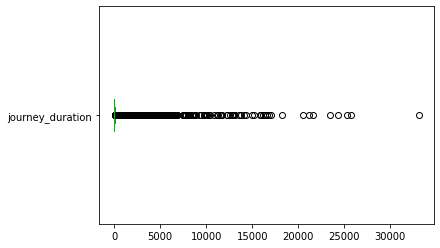

In [19]:
combined_data['journey_duration'].plot.box(vert=False)

This boxplot is not very informative becuase there very large outliers that are squashing the important data. This could be due many reasons but ultimatley the individuals not going to ending bike station for a long time. 


In [20]:
# Removes all rows where the start date and end date are different
combined_data = combined_data.loc[combined_data['formatted_start_date'] == combined_data['formatted_end_date']]



I remove this data because I will not be able to account for the temperature on the rows that overlap into different days.

<AxesSubplot:>

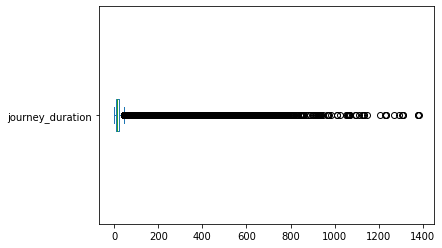

In [21]:
combined_data['journey_duration'].plot.box(vert=False)

This still yields a the large number of outliers. Even with the dates accounted for the variance is still very large. To visualise this data and explain will be difficult.

In [22]:
combined_data['journey_duration'].std()

29.12948584200261

In [23]:
# Creat a data subset the data to exclude extreme values
lower_extremes = combined_data['journey_duration'].quantile(0.10)
upper_extremes = combined_data['journey_duration'].quantile(0.90)
combined_data_subset = combined_data[(combined_data['journey_duration'] > lower_extremes) & (combined_data['journey_duration'] < upper_extremes)]


I exclude the extreme values from the dataset to improve the accuracy and interpretability of the analysis and moddelling if neccessary. Outliers can skew the distribution and hide the more representative values in the dataset. Doing this allows me to  focus on the more typical values and create visualizations that are easier to understand and produce more meaningful conclusions. 

<AxesSubplot:>

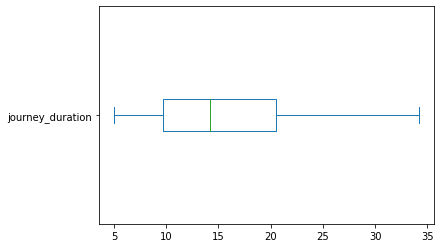

In [24]:
combined_data_subset['journey_duration'].plot.box(vert=False)

There are no outliers so I can reap the benifits made in the last paragraph. Moreover this column was the only column this had to be altered to this extent due to the variance. Now I can start to analyse the data.

## Analysis


### 1. Affect of Weather on journey duration 



In [25]:
# calculate correlation coefficients
corr_matrix = combined_data_subset[['journey_duration', 'prcp_(mm)', 'tavg_(celsius)']].corr()

# print the correlation coefficients
print(corr_matrix)


                  journey_duration  prcp_(mm)  tavg_(celsius)
journey_duration          1.000000  -0.013502        0.001954
prcp_(mm)                -0.013502   1.000000       -0.158594
tavg_(celsius)            0.001954  -0.158594        1.000000


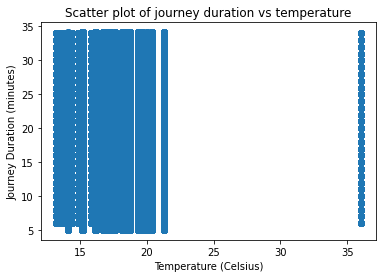

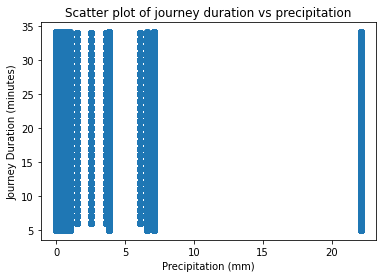

In [26]:
# Create a scatter plot of journey duration vs temperature
plt.scatter(combined_data_subset['tavg_(celsius)'], combined_data_subset['journey_duration'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Journey Duration (minutes)')
plt.title('Scatter plot of journey duration vs temperature')
plt.show()

# Create a scatter plot of journey duration vs precipitation
plt.scatter(combined_data_subset['prcp_(mm)'], combined_data_subset['journey_duration'])
plt.xlabel('Precipitation (mm)')
plt.ylabel('Journey Duration (minutes)')
plt.title('Scatter plot of journey duration vs precipitation')
plt.show()

In [27]:
# Group the data by temperature and calculate the mean journey duration
mean_duration_by_temp = combined_data_subset.groupby('tavg_(celsius)')['journey_duration'].mean()

# Group the data by precipitation and calculate the mean journey duration
mean_duration_by_prcp = combined_data_subset.groupby('prcp_(mm)')['journey_duration'].mean()


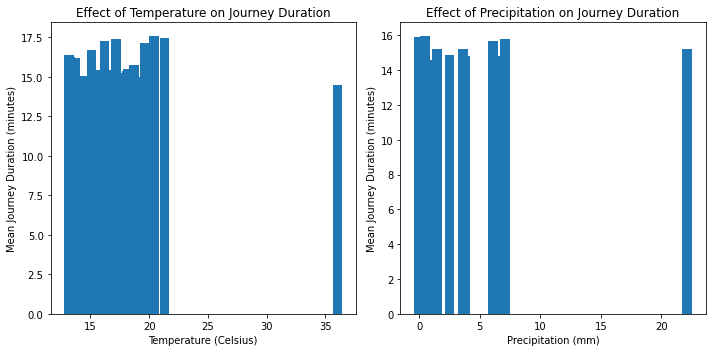

In [28]:
# Create two bar plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Bar plot for temperature
axs[0].bar(mean_duration_by_temp.index, mean_duration_by_temp.values)
axs[0].set_xlabel('Temperature (Celsius)')
axs[0].set_ylabel('Mean Journey Duration (minutes)')
axs[0].set_title('Effect of Temperature on Journey Duration')

# Bar plot for precipitation
axs[1].bar(mean_duration_by_prcp.index, mean_duration_by_prcp.values)
axs[1].set_xlabel('Precipitation (mm)')
axs[1].set_ylabel('Mean Journey Duration (minutes)')
axs[1].set_title('Effect of Precipitation on Journey Duration')

plt.tight_layout()
plt.show()

### 1.1 Affect of Weather on cycle volume


In [29]:
# group by formatted_start_date and count the number of rows
cycle_volume = combined_data_subset.groupby('formatted_start_date').size().reset_index(name='counts')

cycle_volume.head()

,formatted_start_date,counts
0,01/08/2017,31850
1,01/09/2017,28192
2,02/08/2017,22387
3,02/09/2017,25507
4,03/08/2017,27838


In [30]:
# merge counts_by_date with combined_data on formatted_start_date
merged_data = pd.merge(cycle_volume, combined_data_subset, on='formatted_start_date')

# calculate correlation between counts and tavg_(celsius)
corr_tavg = merged_data['counts'].corr(merged_data['tavg_(celsius)'])

# calculate correlation between counts and prcp_(mm)
corr_prcp = merged_data['counts'].corr(merged_data['prcp_(mm)'])


In [31]:
print(corr_tavg)
print(corr_prcp)

-0.015603184020574506
-0.02970366664357701


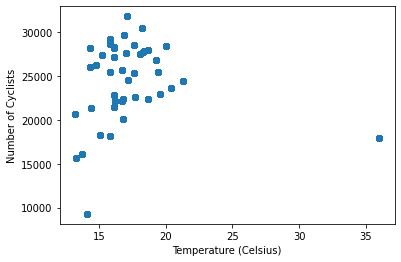

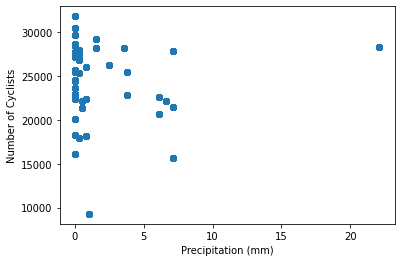

In [32]:
# create scatter plot of counts and temperature
plt.scatter(merged_data['tavg_(celsius)'], merged_data['counts'])
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Number of Cyclists')
plt.show()

# create scatter plot of counts and precipitation
plt.scatter(merged_data['prcp_(mm)'], merged_data['counts'])
plt.xlabel('Precipitation (mm)')
plt.ylabel('Number of Cyclists')
plt.show()


### 2. The usefulness and performance of trying to predict cycle volumes

In [56]:
# Split the dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(merged_data[['tavg_(celsius)', 'prcp_(mm)']], merged_data['counts'], test_size=0.2, random_state=42)

In [58]:
# Compare the performance of the models with a baseline model
mean_cycle_volume = merged_data['counts'].mean()
mean_cycle_volume_pred = [mean_cycle_volume] * len(y_test)
mean_cycle_volume_r2 = r2_score(y_test, mean_cycle_volume_pred)

print('Baseline Model (Predicting Mean Cycle Volume) - R-squared: ', mean_cycle_volume_r2)

Baseline Model (Predicting Mean Cycle Volume) - R-squared:  -1.537890033209699e-05


In [59]:
# Train and evaluate a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
lin_reg_pred = lin_reg.predict(x_test)
lin_reg_r2 = r2_score(y_test, lin_reg_pred)

# Print the evaluation metrics
print('Linear Regression - R-squared: ', lin_reg_r2)

Linear Regression - R-squared:  0.001276975394734703


In [60]:
poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Train and evaluate a linear regression model
poly_reg = LinearRegression()
poly_reg.fit(x_train_poly, y_train)
poly_reg_pred = poly_reg.predict(x_test_poly)
poly_reg_r2 = r2_score(y_test, poly_reg_pred)

print('Polynomial Regression - R-squared: ', poly_reg_r2)

Polynomial Regression - R-squared:  0.23256845189710518


In [61]:
# Train and evaluate a decision tree regression model
dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train, y_train)
dt_reg_pred = dt_reg.predict(x_test)
dt_reg_r2 = r2_score(y_test, dt_reg_pred)

print('Decision Tree Regression - R-squared: ', dt_reg_r2)

Decision Tree Regression - R-squared:  0.9919879716961221


In [62]:
# Train and evaluate a neural network regression model
nn_reg = MLPRegressor(hidden_layer_sizes=(1, 1), activation='relu', solver='adam')
nn_reg.fit(x_train, y_train)
nn_reg_pred = nn_reg.predict(x_test)
nn_reg_r2 = r2_score(y_test, nn_reg_pred)

print('Neural Network Regression - R-squared: ', nn_reg_r2)

Neural Network Regression - R-squared:  0.0010997615813220785


### 3. Where to add another station

In [ ]:
# Analyze the distribution of bike journeys and bike stations
# Plot the distribution of bike journeys by station
bike_journeys_by_station = bike_data.groupby(['start_station_id'])['cycle_volume'].sum().reset_index()
bike_journeys_by_station.plot(kind='hist', bins=20, title='Distribution of Bike Journeys by Station')

# Plot the distribution of bike stations by location
bike_stations_by_location = bike_data.groupby(['start_latitude', 'start_longitude'])['start_station_id'].count().reset_index()
bike_stations_by_location.plot(kind='scatter', x='start_longitude', y='start_latitude', title='Distribution of Bike Stations by Location')

# Use clustering techniques to group bike journeys and bike stations into clusters based on their geographical locations and attributes
# Cluster bike journeys by location
journey_data = bike_data[['start_latitude', 'start_longitude']]
kmeans_journeys = KMeans(n_clusters=5, random_state=42).fit(journey_data)
journey_data['journey_cluster'] = kmeans_journeys.labels_

# Cluster bike stations by location
station_data = bike_data[['start_station_id', 'start_latitude', 'start_longitude']]
station_data = station_data.drop_duplicates(subset=['start_station_id'])
station_data = station_data.drop(columns=['start_station_id'])
kmeans_stations = KMeans(n_clusters=5, random_state=42).fit(station_data)
station_data['station_cluster'] = kmeans_stations.labels_

# Identify clusters with high demand and low supply of bike stations
# Calculate the average number of bike journeys per station per cluster
journeys_by_cluster = journey_data.merge(bike_data[['start_station_id', 'cycle_volume']], left_index=True, right_on='start_station_id')
journeys_by_cluster = journeys_by_cluster.groupby(['start_station_id', 'journey_cluster'])['cycle_volume'].mean().reset_index()
avg_journeys_per_station = journeys_by_cluster.groupby(['journey_cluster'])['cycle_volume'].mean().reset_index()
avg_journeys_per_station = avg_journeys_per_station.rename(columns={'cycle_volume': 'avg_journeys_per_station'})

# Calculate the number of bike stations per cluster
stations_by_cluster = station_data.groupby(['station_cluster']).size().reset_index(name='num_stations')

# Merge the two datasets to identify clusters with high demand and low supply of bike stations
clusters = avg_journeys_per_station.merge(stations_by_cluster, left_on='journey_cluster', right_on='station_cluster')
clusters['demand_supply_ratio'] = clusters['avg_journeys_per_station'] / clusters['num_stations']

# Recommend locations for new bike stations
recommended_locations = station_data.merge(clusters[['journey_cluster', 'demand_supply_ratio']], left_on='station_cluster', right_on='journey_cluster')
recommended_locations = recommended_locations[recommended_locations['demand_supply_ratio'] > 1.0]
recommended_locations = recommended_locations[['start_station_id', 'start_latitude', 'start_longitude']]

# Plot the recommended locations for new bike stations
bike_stations_by_location.plot(kind='scatter', x='start_longitude', y='start_latitude', title='Distribution of Bike Stations by Location and Recommended Locations for New Bike Stations')
plt.scatter(recommended_locations['start_longitude'], recommended_locations['start_latitude'], color='red', s=100)
plt.show()
